In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [2]:
amps = False
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpKLAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpKL
    import cklemap.ckli.mapest_old as mapest

In [3]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [4]:
# Parameters
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 200
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
res_fac = 1
resolution = '4x'
resolution_ref = '1x'
resolution_iYobs = '16x'
lsq_method = 'trf'
data_path = '../data/'
results_path = '../results'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_ref_filename= data_path + f'geom/geom_{resolution_ref}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF1/conduct_log_RF1_{resolution_ref}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
yobs_fine_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = f'Yref=orig_interpolated_{resolution}'

In [5]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [6]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [7]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [8]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [9]:
geom_fine = GeomMRST(geom_fine_filename)

if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
elif os.path.exists(yobs_fine_filename):
    print(f"iYobs set read from file {yobs_fine_filename} and randomly selected nearby cell")
    iYobs_fine = np.load(yobs_fine_filename)
    geom_fine = GeomMRST(geom_ref_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs_ref = np.array([geom_ref.cellsContain(geom_fine.cells.centroids.T[iYobs[t]]) for t in range(num_trials)])
iYlearn = iYobs_ref
Ylearn = np.array([Yref_orig[iYlearn[t]] for t in range(num_trials)])

iYobs set read from file ../data/yobs/yobs_200_16x.npy
iYobs.shape=(10, 200)
[[   18    31    45 ... 23140 23353 23484]
 [    0   179   270 ... 22989 23049 23291]
 [   53   216   388 ... 23284 23342 23412]
 ...
 [  134   171   204 ... 23390 23412 23559]
 [  269   459   462 ... 23515 23558 23575]
 [    4   192   211 ... 23031 23411 23537]]


In [10]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yref = np.zeros((num_trials, Nc))
CYref = np.zeros((num_trials, Nc, Nc))
Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yest = np.zeros((num_trials, Nc))

In [11]:
for t in range(num_trials):
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:, iYlearn[t]].T, Ylearn[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Yref[t], CYref[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   2.907108e+02   2.033698e+04 
    00s10  0015   2.326504e+02   4.761527e+00 
    00s17  0026   2.303508e+02   7.308149e-03 
    00s19  0030   2.303473e+02   3.056720e-06 
    00s25  0043   2.303471e+02   4.986653e-11 
Runtime:     00s25
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   4.595307e+02   1.412548e+06 
    00s03  0005   2.912700e+02   1.437929e+05 
    00s03  0006   2.565948e+02   3.549184e+04 
    00s07  0012   2.009823e+02   5.075348e+01 
    00s11  0018   1.956215e+02   2.609080e+01 
    00s16  0026   1.951491e+02   9.464238e-03 
    00s19  0031   1.951469e+02   1.789461e-05 
    00s23  0040   1.951466e+02   5.085727e-11 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  

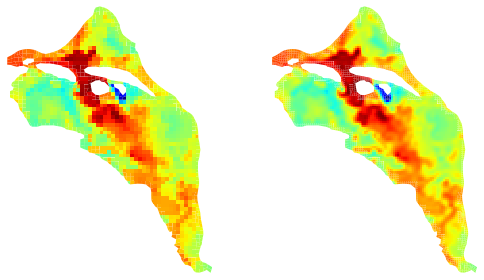

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref[0] + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(f'../figures/Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [13]:
# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
Nuobs = iuobs.size

prob = DarcyExp(TPFA(geom, bc), None)

uref = np.array([prob.solve(Yref[t]) for t in range(num_trials)])
uobs = uref[:, iuobs]

In [14]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=200_Nu=408_NYlearn=200_NYxi=1000_gamma=1e-06_cklmap_h1reg_amps=False_Yref=orig_interpolated_4x


In [15]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[t, iYlearn]
    Yobs[t] = Yref[t, iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

IndexError: index 6144 is out of bounds for axis 1 with size 5900

In [16]:
# PICKLE models
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.89157453 0.88908308 0.88245192 0.89825678 0.87910347 0.88469324
 0.88477788 0.87883266 0.86841481 0.88279561]
GPR	Infinity error: [6546.65204188 6558.20564895 6474.78598328 6685.27889854 6538.1293583
 6512.77188418 6556.3465905  6428.58472909 6428.57367115 6486.43055032]


In [17]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [12.92290644 12.93076047 13.08236599 12.92759864 12.80753387 12.84861531
 13.03147498 13.30611424 13.15732596 13.04546789] s


In [18]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs[t], iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(loss.val, loss.grad_u, loss.grad_Y, prob.partial_solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t], prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs)
    else:
        dasa = DASAExpKL(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t])
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKLEMAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref[t]) for t in range(num_trials)])

print(f"CKLEMAP: {timings[:, 4]} s")
print(f"CKLEMAP relative L2 error: {rel_errors[:, 2]}")
print(f"CKLEMAP absolute infinity error: {abs_errors[:, 2]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.5752e+02                                    1.67e+02    
       1              2         1.5250e+02      2.05e+02       1.00e+00       4.28e+01    
       2              3         4.5649e+01      1.07e+02       2.00e+00       2.17e+01    
       3              4         1.0397e+01      3.53e+01       4.00e+00       2.30e+01    
       4              5         8.7823e-01      9.52e+00       8.00e+00       5.13e+00    
       5              7         3.8553e-02      8.40e-01       4.00e+00       4.98e-01    
       6              9         1.5841e-02      2.27e-02       2.00e+00       6.99e-01    
       7             10         1.0762e-02      5.08e-03       4.00e+00       6.88e-01    
       8             11         3.4018e-03      7.36e-03       4.00e+00       2.94e-01    
       9             13         1.7960e-03      1.61e-03       2.00e+00       3.60e-02    

In [19]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest)

In [20]:
t = 0

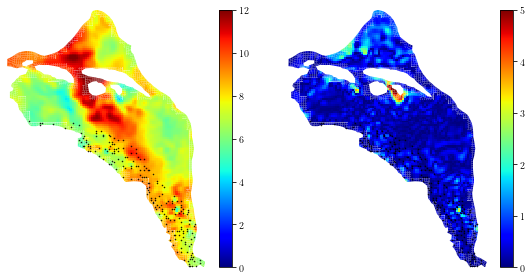

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_patch(patches, Yest[t] + Yfac, fig, ax[0], geom.cells.centroids[:, iYobs[t]], 'Yest_CKLEMAP', 0, 12, True)
plot_patch(patches, np.abs(Yest[t] - Yref[t]), fig, ax[1], geom.cells.centroids[:, iYobs[t]], '|Yest_CKLEMAP - Yref|', 0, 5, True)

fig.tight_layout()